In [ ]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

## Table of contents
<div id="toc"></div>

In [51]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import CalHMM

In [55]:
folder = '/Users/daiyiluo/Downloads/KQ095_210205' #KQ086_210110' #

# 1. Preprocess

## 1.1. Align Behaviour Data with Trace Data
### Fish's Data
### a. Load data

In [3]:
#----- find shape of trace data -----#

data = loadmat(f'{folder}/dFishQ_raw.mat')
data.keys() # check the name of the variable

dict_keys(['__header__', '__version__', '__globals__', 'B'])

In [5]:
key = 'B' # 'B' for CA1 data, 'dFishQ_raw' for CA3 data
traces = data[key]
del data
print(f'Shape of calcium traces: {traces.shape}')

Shape of calcium traces: (96593, 219)


In [ ]:
#----- load behaviour data -----#

data = loadmat(f'{folder}/S.mat')
data.keys()

In [ ]:
key = 'S'
data[key].dtype

In [ ]:
# Locate the time point of each frame
FrameClock = np.round(data[key][0,0]['frameClock'])
d = np.diff(np.squeeze(FrameClock>4.5).astype(int))
idx = np.where(d<-0.5)[0]

print(f'Check if this equals to 2. \n #clock - #frames: {idx.shape[0]-traces.shape[0]}')

In [ ]:
distance = data[key][0,0]['distance'].squeeze()
speed = data[key][0,0]['runSpeed'].squeeze()
lick = data[key][0,0]['lick'].squeeze()

del data

distance.shape, speed.shape, lick.shape, traces.shape

### b. Downsample behaviour data to frame rate

In [ ]:
val, counts = np.unique(np.diff(idx), return_counts=True)
print(f'Frame interval: \n{val[counts>5]}\nOccurrence:     \n{counts[counts>5]}')
print('\nThen decide the frameinterv var below...')

In [ ]:
frameinterv = 333  # most frame interval is 333 or 334
lk0 = np.convolve(lick, np.ones(frameinterv), 'valid') / frameinterv 
halflen = np.floor(frameinterv/2).astype('int16')
lk0 = np.concatenate((np.zeros(halflen),lk0, np.zeros(halflen)))
lk = lk0[idx[:-2]]

dis = distance[idx[:-2]]
spd = speed[idx[:-2]]

spd.shape,dis.shape,lk.shape

### c. Check time point of each frame

In [ ]:
#-------- Check every thing ---------#
# Same lap length for every lap?
%matplotlib
plt.figure(figsize=(20,5))
plt.plot(FrameClock)
plt.plot(distance)
plt.plot(speed)
plt.plot(idx, FrameClock[idx], '*')
plt.show()

In [ ]:
#-------- Check licking rate downsampleing --------#
plt.figure()
plt.plot(lick)
plt.plot(idx[:-2],lk,'*')
plt.plot(lk0)

In [ ]:
#-------- Check speed downsampleing --------#
plt.plot(speed)
plt.plot(idx[:-2], spd)
# plt.xlim(4e6, 4.5e6)
plt.ylabel('speed')

### d. Save data with same sampling rate

In [ ]:
spd.shape,dis.shape,lk.shape

In [ ]:
# check if you need to truncate the data
st = 0
end = len(lk)
np.savez(f'{folder}/S.npz', spd=spd[st:end], dis=dis[st:end], lk=lk[st:end])

### e. Deconvolution for spike data

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from caiman.source_extraction import cnmf

In [ ]:
traces.shape

In [ ]:
spks = np.zeros_like(traces)
for i in range(traces.shape[1]):
    _, _, _, _, _, spks[:,i], _ = cnmf.deconvolution.constrained_foopsi(traces[:,i],p=2)

print(f'Shape of deconvolved spikes: {spks.shape}')

In [ ]:
np.savez(f'{folder}/spk.npz', spks=spks)

In [6]:
spks = np.load(f'{folder}/spk.npz')['spks']

In [ ]:
spks = np.round(spks*50)

In [ ]:
%matplotlib
plt.figure()
plt.plot(traces[:,20])
plt.plot(spks[:,20])

## 1.2. Sort into time bins and exclude immobile epoch
### a. Load data

In [7]:
print(f'{folder}/S.npz')
print(traces.shape)
print(spks.shape)

/Users/daiyiluo/Downloads/KQ095_210205/S.npz
(96593, 219)
(96593, 219)


In [8]:
# traces = traces[st:end,:] # for CA3 0212 data

data = np.load(f'{folder}/S.npz')
spd = data['spd']
dis = data['dis']
lk = data['lk']

del data

spd.shape, dis.shape, lk.shape

((96593,), (96593,), (96593,))

### b. Sort into time bin

In [25]:
new_tb = 333.4  # 2Hz: 500ms
ratio = int(30*new_tb/1000)
ratio

10

In [10]:
# Sample speed to 2Hz
avgspd = np.convolve(spd, np.ones(ratio)/ratio, mode='valid')
avgspd = avgspd[::ratio]

# Sample position to 2Hz
idx_dis = np.arange(round(ratio/2), len(dis)-ratio, ratio)
avgdis = dis[idx_dis]

avgspd.shape, avgdis.shape

((3219,), (3219,))

---------- Trace -----------

In [11]:
# Sample traces to 2Hz
avgtrc = []
for i in range(traces.shape[1]):
    t = np.convolve(traces[:,i], np.ones(ratio)/ratio, mode='valid')
    avgtrc.append(t[::ratio])    
avgtrc = (np.vstack(avgtrc)).T

avgtrc.shape

(3219, 219)

--------- Spikes --------

In [12]:
# Sample spks to 2Hz
avgspk = []
for i in range(spks.shape[1]):
    t = np.convolve(spks[:,i], np.ones(ratio)/ratio, mode='valid')
    avgspk.append(t[::ratio]*ratio)    
avgspk = (np.vstack(avgspk)).T

avgspk.shape

(3219, 219)

### c. Exclude immobile time bins 

In [13]:
spd_thr = 0.02 # 0.02 for 1s tb, 0.03 for 200/500 ms
pass_thr = np.where(avgspd>spd_thr)[0]
%matplotlib
plt.plot(avgspd)
plt.plot(pass_thr,avgspd[pass_thr],'*')
plt.plot([0,len(avgspd)], [spd_thr,spd_thr])

Using matplotlib backend: MacOSX


In [14]:
Distance = avgdis[avgspd>spd_thr]
idx = idx_dis[avgspd>spd_thr] # for licking data because it is not sorted into 500ms time bins
Distance.shape, idx.shape

((1019,), (1019,))

---------- Trace -----------

In [15]:
Trace = avgtrc[avgspd>spd_thr,:]
Trace.shape

(1019, 219)

--------- Spikes --------

In [16]:
Spike = avgspk[avgspd>spd_thr,:]
Spike.shape

(1019, 219)

In [ ]:
for i in range(Spike.shape[1]):
    plt.plot(Spike[:,i]/np.max(Spike[:,i])+i)

### d. Sort into spatial bins and Locate laps

In [17]:
nbin = 50 # expected number of spatial bins
n = np.floor(1/(avgdis.max()/nbin))
Distance0 = np.round(Distance*n)/n # round the distance
np.unique(Distance0).shape, Distance0.shape

((50,), (1019,))

In [18]:
Distance = Distance0

d = np.diff(Distance)
lap_end = np.where(d<-1.6)[0] # Locate the point where the laps end
Distance = Distance[lap_end[0]:]
idx = idx[lap_end[0]:]
f=lap_end[0]
Distance.shape, f

((994,), 25)

---------- Trace -----------

In [19]:
Trace = Trace[f:]
Trace.shape, Distance.shape, idx.shape

((994, 219), (994,), (994,))

In [20]:
lap_end = lap_end-lap_end[0]
np.savez(f'{folder}/timebin_{new_tb}.npz', Trace=Trace, Distance=Distance, lap_end=lap_end, idx=idx)

--------- Spikes --------

In [21]:
Spike = Spike[f:]
Spike.shape, Distance.shape, idx.shape

((994, 219), (994,), (994,))

In [22]:
np.save(f'{folder}/timebin_{new_tb}_spks.npy', Spike)

--------- check the distance sorting --------

In [ ]:
# dis = np.load(f'{folder}/S.npz')['dis']
# plt.plot(dis)
# plt.plot(idx,Distance,'o')
# plt.plot(idx[lap_end], dis[idx[lap_end]],'*')
# plt.xlim(0, 4000)

# 2. Run Trace HMM

In [ ]:
spc_folder = f'{folder}'
spc_folder

In [ ]:
import hmmlearn.hmm

In [ ]:
import imp
imp.reload(CalHMM)

In [ ]:
data = np.load(f'{spc_folder}/timebin_500.npz') #{folder}/timebin_500.npz
Trace = data['Trace']
Distance = data['Distance']
lap_end = data['lap_end']
idx = data['idx']
del data

lk = np.load(f'{folder}/S.npz')['lk']

Trace.shape, Distance.shape, idx.shape, lk.shape

## Segment data or Exclude cells

In [ ]:
Trace.shape

In [ ]:
# Save original copy
Trace0 = Trace.copy()
Distance0 = Distance.copy()
lap_end0 = lap_end.copy()

In [ ]:
#--------- Segment the traces ---------#
st = 0
end = 831
Trace=Trace0[st:end,:]
Distance=Distance0[st:end]
lap_end=lap_end0[np.where((lap_end0>st)&(lap_end0<end))]-st
print(f'Trace shape: {Trace.shape}, Distance shape: {Distance.shape}')

In [ ]:
#--------- Exclude some cells ---------#

# 1. Delete one specific cell
# l=np.arange(219)
# l=np.delete(l,177)

# 2. Randomly select 110 cells
l = np.random.choice(219, size=110,replace=False)

Trace=Trace[:,l]
Trace.shape

## 2.1. Original data

In [ ]:
org_err_rate = []
org_dev = []

for i in range(20):
    origin = hmmlearn.hmm.GaussianHMM(n_components=20) 
    origin.fit(Trace)
    _, _, _, posterior_states1, pos_COM1 = CalHMM.comp_poststates_pos(origin, Trace, Distance)
    err_rate1, dev1, _ = CalHMM.comp_decoded_pos_acc(Distance, posterior_states1, pos_COM1)
    org_err_rate.append(err_rate1)
    org_dev.append(dev1)

In [ ]:
len(org_err_rate)

In [ ]:
save_org_err_rate = np.array(org_err_rate)
save_org_dev = np.array(org_dev)
save_org_err_rate.mean()

In [ ]:
np.savez(f'{spc_folder}/org_err_rate.npz', save_org_err_rate=save_org_err_rate, save_org_dev=save_org_dev)

## 2.2. Time shuffle data

In [ ]:
ts_err_rate = []
ts_dev = []

plt.figure(figsize=(15,4))
plt.plot(Trace[200:500,9])

for i in range(20):
    ts_Trace = CalHMM.get_time_shuffle(Trace)
    plt.plot(ts_Trace[200:500,9])
    
    ts = hmmlearn.hmm.GaussianHMM(n_components=20) 
    ts.fit(ts_Trace) 
    _, _, _, posterior_states2, pos_COM2 = CalHMM.comp_poststates_pos(ts, Trace, Distance)
    err_rate2, dev2, _ = CalHMM.comp_decoded_pos_acc(Distance, posterior_states2, pos_COM2)
    ts_err_rate.append(err_rate2)
    ts_dev.append(dev2)

In [ ]:
len(ts_err_rate)

In [ ]:
save_ts_err_rate = np.array(ts_err_rate)
save_ts_dev = np.array(ts_dev)
save_ts_err_rate.mean()

In [ ]:
np.savez(f'{spc_folder}/ts_err_rate.npz', save_ts_err_rate=save_ts_err_rate, save_ts_dev=save_ts_dev)

## 2.3. Transient shuffle data

In [ ]:
trsn_err_rate = []
trsn_dev = []

plt.figure(figsize=(15,4))
plt.plot(Trace[200:500,9])

for i in range(20):
    trsn_shf = CalHMM.get_trsn_shuffle(Trace)
    plt.plot(trsn_shf[200:500,9])
    
    trsn = hmmlearn.hmm.GaussianHMM(n_components=20) 
    trsn.fit(trsn_shf)  
    _, _, _, posterior_states3, pos_COM3 = CalHMM.comp_poststates_pos(trsn, Trace, Distance)
    err_rate3, dev3, _ = CalHMM.comp_decoded_pos_acc(Distance, posterior_states3, pos_COM3)
    trsn_err_rate.append(err_rate3)
    trsn_dev.append(dev3)

In [ ]:
save_trsn_err_rate = np.array(trsn_err_rate)
save_trsn_dev = np.array(trsn_dev)
save_trsn_err_rate.mean()

In [ ]:
np.savez(f'{spc_folder}/trsn_err_rate.npz', save_trsn_err_rate=save_trsn_err_rate, save_trsn_dev=save_trsn_dev)

### Compare

In [ ]:
# plt.boxplot([save_org_err_rate, save_ts_err_rate, save_trsn_err_rate])
# plt.xticks(np.arange(1,4), ['origin','time shuffle', 'transient shuffle'])
plt.boxplot([save_org_err_rate, save_ts_err_rate])
plt.xticks(np.arange(1,3), ['origin','time shuffle'])

plt.ylabel('Average error rate')
plt.title('CA1 first day\n200ms time bin')
plt.show()

In [ ]:
save_org_err_rate[-1], save_ts_err_rate[-1], save_trsn_err_rate[-1]

## 2.4. Save and reload

In [ ]:
save = False
if save==True:
    CalHMM.save_object(origin, f'{spc_folder}/origin.pkl')
    CalHMM.save_object(ts, f'{spc_folder}/ts.pkl')
    CalHMM.save_object(trsn, f'{spc_folder}/trsn.pkl')

In [ ]:
origin = CalHMM.load_object(f'{spc_folder}/origin.pkl')
ts = CalHMM.load_object(f'{spc_folder}/ts.pkl')
trsn = CalHMM.load_object(f'{spc_folder}/trsn.pkl')

In [ ]:
origin.score(Trace), ts.score(Trace), trsn.score(Trace)

In [ ]:
prob = []
for i in range(len(lap_end)-1):
    prob.append(origin.score(Trace[lap_end[i]:lap_end[i+1]])/(lap_end[i+1]-lap_end[i]))

In [ ]:
plt.plot(prob)
plt.ylim(-500,300)
np.array(prob).mean()

In [ ]:
prob2 = []
for i in range(len(lap_end)-1):
    prob2.append(ts.score(Trace[lap_end[i]:lap_end[i+1]])/(lap_end[i+1]-lap_end[i]))

In [ ]:
plt.plot(prob2)
plt.ylim(-500,300)
np.array(prob2).mean()

In [ ]:
plt.plot(prob2)
plt.ylim(-500,300)

## 2.5. Visualizations
### 2.5.1. Regular

In [ ]:
%matplotlib inline
v = .2

In [ ]:
x1, plst1, occ1, T1, posterior_states1, pos_COM1 = CalHMM.show_all_plots(origin, Trace, Distance, lap_end, t_st=1200, t_duration=500,vmax=v)

In [ ]:
x2, plst2, occ2, T2, posterior_states2, pos_COM2 = CalHMM.show_all_plots(ts, Trace, Distance, lap_end, t_st=1200, t_duration=500, vmax=v)

In [ ]:
x3, plst3, occ3, T3, posterior_states3, pos_COM3 = CalHMM.show_all_plots(trsn, Trace, Distance, lap_end, t_st=1200, t_duration=500, vmax=v)

### Check cell asembly coactivation

In [ ]:
origin.means_.shape

In [ ]:
n=plst1[8]
means=origin.means_[n,:]
thr=means.mean()+3*means.std()
nn=np.where(origin.means_[n,:]>thr)[0]
plt.plot(means)
plt.plot([0,110],[thr,thr])
plt.plot(nn, means[nn],'*')
print(nn)

In [ ]:
plt.figure(figsize=(15,4))
for j,i in enumerate(nn):
    t=Trace[:,i].copy()
    t=t/np.max(t)
    plt.plot(t+j, label=f'{i}')
plt.legend()

### 2.5.2. Decoded states of all frames

In [ ]:
_, plst, _, posterior_states = CalHMM.comp_poststates_pos(origin, Trace, Distance)
%matplotlib
CalHMM.plot_postprob(posterior_states, plst, lap_end, t_st=0, t_duration=len(Distance))

In [ ]:
plt.xlim(800,1200)

### 2.5.3. Decoded states and behaviour

In [ ]:
lk = np.load(f'{folder}/S.npz')['lk']
lk.shape

In [ ]:
i,ct=np.unique(np.diff(idx),return_counts=True)
i,ct

In [ ]:
idx[np.where(np.diff(idx)>15)[0]]

In [ ]:
plt.plot(idx, Distance, '.')
i=np.where(np.diff(idx)>15)[0]
plt.plot(idx[i],Distance[i],'*')

In [ ]:
def plot_decoded_pos(Distance, Decoded_pos, lap_end, idx, lk, ax1=None, ax2=None, t_st=400, t_duration=200):
    num = np.where((lap_end>t_st)&(lap_end<t_st+t_duration))[0]
    if ax1==None:
        _, ax1 = plt.subplots(figsize=(15,3))
    ax1.plot(lk[idx[t_st]:idx[t_st+t_duration]]/4, '.', label='lick')
    for i in num:
        ax1.plot([idx[lap_end[i]]-idx[t_st],idx[lap_end[i]]-idx[t_st]],[0,2], 'r--')
    ax1.set_xlim(0,idx[t_st+t_duration]-idx[t_st])
    ax1.legend()

    if ax2==None:
        _, ax2 = plt.subplots(figsize=(15,3))
    ax2.plot(idx[t_st:t_st+t_duration]-idx[t_st], Decoded_pos[t_st:t_st+t_duration],'o', label='decoded position')
    ax2.plot(idx[t_st:t_st+t_duration]-idx[t_st], Distance[t_st:t_st+t_duration],'.', label='real position')
    for i in num:
        ax2.plot([idx[lap_end[i]]-idx[t_st],idx[lap_end[i]]-idx[t_st]],[0,2], 'r--')
    ax2.set_xlim(0,idx[t_st+t_duration]-idx[t_st])
    ax2.legend()

In [ ]:
err_rate, dev, Decoded_pos = CalHMM.comp_decoded_pos_acc(Distance, posterior_states1, pos_COM1)
plot_decoded_pos(Distance, Decoded_pos, lap_end, idx, lk, ax1=None, ax2=None, t_st=400, t_duration=200)

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(Decoded_pos, label='decoded position')
plt.plot(Distance, label='real position')
for i in range(len(lap_end)):
    plt.plot([lap_end[i],lap_end[i]],[0,2], 'r--')
plt.xlim(900,1800)
plt.legend()

In [ ]:
lap_end[-1]

# 3. Run Spike HMM

In [56]:
spc_folder = f'{folder}'
spc_folder

'/Users/daiyiluo/Downloads/KQ095_210205'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
import hmmlearn.hmm

In [ ]:
import imp
imp.reload(CalHMM)

In [57]:
data = np.load(f'{spc_folder}/timebin_500.npz') #{folder}/timebin_500.npz
Distance = data['Distance']
lap_end = data['lap_end']
idx = data['idx']
del data

Spike = np.load(f'{spc_folder}/timebin_500_spks.npy')

Spike.shape, Distance.shape, idx.shape

((1821, 219), (1821,), (1821,))

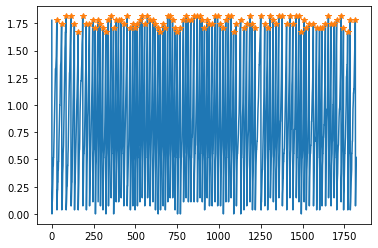

In [59]:
lengths=np.diff(lap_end)
plt.plot(Distance)
plt.plot(np.cumsum(lengths),Distance[np.cumsum(lengths)],'*')

In [60]:
lap_end[0],lap_end[-1],np.sum(lengths),Distance[:lap_end[-1]].shape

(0, 1815, 1815, (1815,))

## Segment data or Exclude cells

In [61]:
# Save original copy
Spike0 = Spike.copy()
Distance0 = Distance.copy()
lap_end0 = lap_end.copy()

In [97]:
%matplotlib

Using matplotlib backend: MacOSX


In [87]:
ts_Spike = np.concatenate([CalHMM.get_time_shuffle(Spike[lap_end[j]:lap_end[j+1],:]) for j in range(len(lap_end)-1)])

In [98]:
plt.figure(figsize=(20,5))
plt.plot(Spike[:,7])
plt.plot(ts_Spike[:,7])
plt.plot(Distance)
for i in range(len(lap_end)-1):
    plt.plot([lap_end[i],lap_end[i]],[0,20],'--')

In [85]:
k=3
n_laps=int((len(lap_end0)-1)/k)
st = [0]
for i in range(k):
    st.append(n_laps*(i+1))
st

[0, 34, 68, 102]

In [86]:
#--------- Segment the traces ---------#
i_k = 1
Spike=Spike0[lap_end0[st[i_k]]:lap_end0[st[i_k+1]],:]
Distance=Distance0[lap_end0[st[i_k]]:lap_end0[st[i_k+1]]]
lap_end=lap_end0[st[i_k]:st[i_k+1]]-lap_end0[st[i_k]]
print(f'Spike shape: {Spike.shape}, Distance shape: {Distance.shape}')

Spike shape: (546, 219), Distance shape: (546,)


In [ ]:
#--------- Exclude some cells ---------#

# 1. Delete one specific cell
# l=np.arange(219)
# l=np.delete(l,177)

# 2. Randomly select 110 cells
l = np.random.choice(219, size=110,replace=False)

Trace=Trace[:,l]
Trace.shape

## 3.1. Original data

In [101]:
org_err_rate = []
org_dev = []

for i in range(1):
    origin = hmmlearn.hmm.PoissonHMM(n_components=20) 
    origin.fit(Spike)
    _, _, _, posterior_states1, pos_COM1 = CalHMM.comp_poststates_pos(origin, Spike, Distance)
    err_rate1, dev1, _ = CalHMM.comp_decoded_pos_acc(Distance, posterior_states1, pos_COM1)
    org_err_rate.append(err_rate1)
    org_dev.append(dev1)

/opt/anaconda3/lib/python3.8/site-packages/hmmlearn/stats.py:103: RuntimeWarning: divide by zero encountered in log
  log_means = np.where(means > 1e-3, np.log(means), np.log(1e-3))
/opt/anaconda3/lib/python3.8/site-packages/hmmlearn/stats.py:103: RuntimeWarning: invalid value encountered in log
  log_means = np.where(means > 1e-3, np.log(means), np.log(1e-3))


In [ ]:
len(org_err_rate)
origin.n_components

In [ ]:
save_org_err_rate = np.array(org_err_rate)
save_org_dev = np.array(org_dev)
save_org_err_rate.mean()

In [ ]:
np.savez(f'{spc_folder}/org_err_rate_spk.npz', save_org_err_rate=save_org_err_rate, save_org_dev=save_org_dev)

## 3.2. Time shuffle data

In [ ]:
ts_err_rate = []
ts_dev = []

plt.figure(figsize=(15,4))
plt.plot(Spike[200:500,9])

for i in range(5):
    ts_Spike = CalHMM.get_time_shuffle(Spike)
    plt.plot(ts_Spike[200:500,9])
    
    ts = hmmlearn.hmm.PoissonHMM(n_components=20) 
    ts.fit(ts_Spike) 
    _, _, _, posterior_states2, pos_COM2 = CalHMM.comp_poststates_pos(ts, Spike, Distance)
    err_rate2, dev2, _ = CalHMM.comp_decoded_pos_acc(Distance, posterior_states2, pos_COM2)
    ts_err_rate.append(err_rate2)
    ts_dev.append(dev2)

In [ ]:
len(ts_err_rate)

In [ ]:
save_ts_err_rate = np.array(ts_err_rate)
save_ts_dev = np.array(ts_dev)
save_ts_err_rate.mean()

In [ ]:
np.savez(f'{spc_folder}/ts_err_rate_spk.npz', save_ts_err_rate=save_ts_err_rate, save_ts_dev=save_ts_dev)

### Compare

In [30]:
name='Spike'
timebin=200
train_by_lap='lap'
CA = 'CA3'
if CA=='CA3':
    fname='KQ086_210110'
else:
    fname='KQ095_210205'
    
data=np.load(f'/Users/daiyiluo/Downloads/{fname}/compare_ori_ts/{name}_{timebin}_err_rate_20_{train_by_lap}.npz')
save_org_err_rate=data['save_org_err_rate']
save_ts_err_rate=data['save_ts_err_rate']

plt.boxplot([data['save_org_err_rate'], data['save_ts_err_rate']])
plt.xticks(np.arange(1,3), ['origin','time shuffle'])

plt.ylabel('Average error rate')
plt.title(f'Spike: {CA} trained by {train_by_lap}\n{timebin}ms time bin')
plt.show()

In [ ]:
save_org_err_rate[-1], save_ts_err_rate[-1]

## 3.3. Save and reload

In [ ]:
save = True
if save==True:
    CalHMM.save_object(origin, f'{spc_folder}/origin.pkl')
    CalHMM.save_object(ts, f'{spc_folder}/ts.pkl')

In [ ]:
origin = CalHMM.load_object(f'{spc_folder}/origin.pkl')
ts = CalHMM.load_object(f'{spc_folder}/ts.pkl')

In [ ]:
# data = np.load('/Users/daiyiluo/Downloads/KQ095_210205/tb_200/timebin_200.npz')
data.files

## 3.4. Visualizations
### 3.4.1. Regular

In [ ]:
%matplotlib inline
v = .2

In [ ]:
x1, plst1, occ1, T1, posterior_states1, pos_COM1 = CalHMM.show_all_plots(origin, Spike, Distance, lap_end, t_st=400, t_duration=400,vmax=v)

In [ ]:
x2, plst2, occ2, T2, posterior_states2, pos_COM2 = CalHMM.show_all_plots(ts, Spike, Distance, lap_end, t_st=200, t_duration=300, vmax=v)

In [ ]:
len(Distance)

### 3.4.2. Decoded states of all frames

In [ ]:
%matplotlib

In [ ]:
# _, plst, _, posterior_states, _ = CalHMM.comp_poststates_pos(origin, Spike, Distance)
CalHMM.plot_postprob(posterior_states, plst, lap_end, t_st=0, t_duration=len(Distance))

In [ ]:
plt.xlim(1600,1820)

### Check cell asembly coactivation

In [ ]:
origin.means_.shape

In [ ]:
st = np.argmax(posterior_states1,axis=1)

In [ ]:
n=plst1[5]
means=origin.means_[n,:]
thr=means.mean()+3*means.std()
nn=np.where(origin.means_[n,:]>thr)[0]
plt.plot(means)
plt.plot([0,110],[thr,thr])
plt.plot(nn, means[nn],'*')
print(nn)

In [ ]:
st_occ = np.where(st==n)[0]
st_occ.shape

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(st_occ, np.zeros_like(st_occ), '*')
for j,i in enumerate(nn):
    t=Spike[:,i].copy()
    t=t/np.max(t)
    plt.plot(t+j, label=f'{i}')
plt.legend()

### 3.4.3. Decoded states and behaviour

In [ ]:
lk = np.load(f'{folder}/S.npz')['lk']
lk.shape

In [ ]:
%matplotlib inline

In [ ]:
def plot_decoded_pos(Distance, Decoded_pos, lap_end, idx, lk, ax1=None, ax2=None, t_st=400, t_duration=200):
    num = np.where((lap_end>t_st)&(lap_end<t_st+t_duration))[0]
    if ax1==None:
        _, ax1 = plt.subplots(figsize=(15,3))
    ax1.plot(lk[idx[t_st]:idx[t_st+t_duration]]/4, '.', label='lick')
    for i in num:
        ax1.plot([idx[lap_end[i]]-idx[t_st],idx[lap_end[i]]-idx[t_st]],[0,2], 'r--')
    ax1.set_xlim(0,idx[t_st+t_duration]-idx[t_st])
    ax1.legend()

    if ax2==None:
        _, ax2 = plt.subplots(figsize=(15,3))
    ax2.plot(idx[t_st:t_st+t_duration]-idx[t_st], Decoded_pos[t_st:t_st+t_duration],'.', label='decoded position')
    ax2.plot(idx[t_st:t_st+t_duration]-idx[t_st], Distance[t_st:t_st+t_duration],'.', label='real position')
    for i in num:
        ax2.plot([idx[lap_end[i]]-idx[t_st],idx[lap_end[i]]-idx[t_st]],[0,-2], 'r--')
    ax2.set_xlim(0,idx[t_st+t_duration]-idx[t_st])
#     ax2.legend()

In [ ]:
t_st=700
t_duration=150
err_rate1, dev1, Decoded_pos1 = CalHMM.comp_decoded_pos_acc(Distance, posterior_states1, pos_COM1)
plot_decoded_pos(-Distance, -Decoded_pos1, lap_end, idx, lk, ax1=None, ax2=None, t_st=t_st, t_duration=t_duration)
CalHMM.plot_postprob(posterior_states1, plst1, lap_end, ax=None, t_st=t_st, t_duration=t_duration)

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(Decoded_pos1, label='decoded position')
plt.plot(Distance, label='real position')
for i in range(len(lap_end)):
    plt.plot([lap_end[i],lap_end[i]],[0,2], 'r--')
plt.xlim(300,600)
plt.legend()

In [ ]:
lap_end[-1]

## Compare time-shuffle and origin HMM (20 iter)

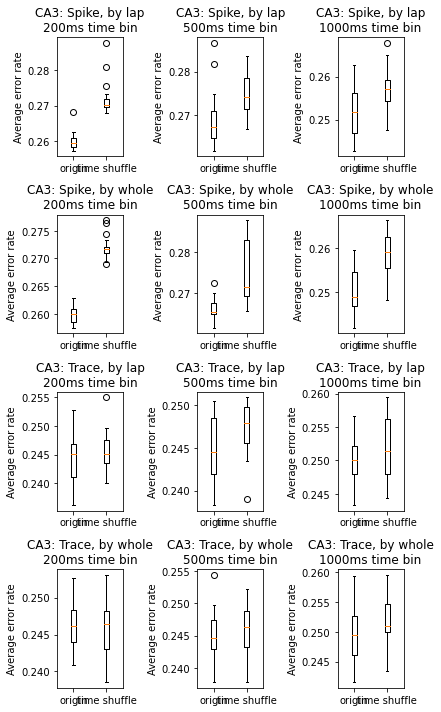

In [6]:
CA='CA3'
if CA=='CA3':
    fname='KQ086_210110'
else:
    fname='KQ095_210205'
    
timebins=[200,500,1000]
train_by_laps=['lap','whole']
names=['Spike','Trace']
    
fig, axs = plt.subplots(4, 3,sharey=False,figsize=(6,10))
for i, timebin in enumerate(timebins):
    k=0
    for name in names:
        for train_by_lap in train_by_laps:
            data=np.load(f'/Users/daiyiluo/Downloads/{fname}/compare_ori_ts/{name}_{timebin}_err_rate_20_{train_by_lap}.npz')
            axs[k,i].boxplot([data['save_org_err_rate'], data['save_ts_err_rate']])
            
            axs[k,i].set_xticks(np.arange(1,3)) 
            axs[k,i].set_xticklabels(['origin','time shuffle'])

            axs[k,i].set_ylabel('Average error rate')
            axs[k,i].set_title(f'{CA}: {name}, by {train_by_lap}\n{timebin}ms time bin')
            
            k+=1

# plt.setp(axs, ylim=(0.12,0.29))
fig.tight_layout()
plt.show()

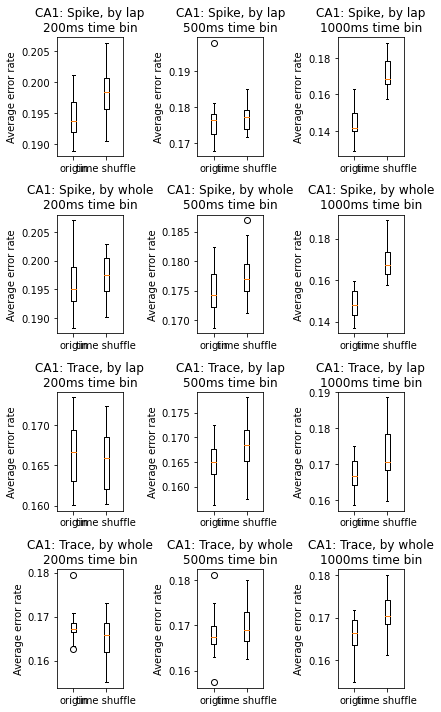

In [73]:
CA='CA1'
if CA=='CA3':
    fname='KQ086_210110'
else:
    fname='KQ095_210205'
    
timebins=[200,500,1000]
train_by_laps=['lap','whole']
names=['Spike','Trace']
    
fig, axs = plt.subplots(4, 3,sharey=False,figsize=(6,10))
for i, timebin in enumerate(timebins):
    k=0
    for name in names:
        for train_by_lap in train_by_laps:
            data=np.load(f'/Users/daiyiluo/Downloads/{fname}/compare_ori_ts/{name}_{timebin}_err_rate_20_{train_by_lap}.npz')
            axs[k,i].boxplot([data['save_org_err_rate'], data['save_ts_err_rate']])
            
            axs[k,i].set_xticks(np.arange(1,3)) 
            axs[k,i].set_xticklabels(['origin','time shuffle'])

            axs[k,i].set_ylabel('Average error rate')
            axs[k,i].set_title(f'{CA}: {name}, by {train_by_lap}\n{timebin}ms time bin')
            
            k+=1
            
fig.tight_layout()
plt.show()

In [71]:
data=np.load(f'/Users/daiyiluo/Downloads/{fname}/compare_ori_ts/{name}_{timebin}_err_rate_20_{train_by_lap}.npz')
data['save_org_err_rate']

array([0.25386643, 0.25934892, 0.25223081, 0.24555333, 0.24586181,
       0.25424908, 0.2516824 , 0.24986189, 0.24628429, 0.24871069,
       0.2538655 , 0.24662874, 0.25015939, 0.24975627, 0.24166507,
       0.25626978, 0.24176173, 0.24150417, 0.24710556, 0.24907768])

In [102]:
fnames=['KQ086_210110','KQ095_210205']
    
timebins=[200,500,1000]
train_by_laps=['lap','whole']
names=['Spike','Trace']
n_iter=20
    
for fname in fnames:
    for timebin in timebins:
        folder=f'/home/della/Downloads/Fish_data/{fname}/tb_{timebin}'
        print(f'{folder}/timebin_{timebin}.npz')
        for name in names:
            for train_by_lap in train_by_laps:
                
                folder_output=f'/home/della/Downloads/Fish_data/{fname}/compare_ori_ts'
                print(f'{folder_output}/{name}_{timebin}_err_rate_20_{train_by_lap}.npz')

/home/della/Downloads/Fish_data/KQ086_210110/tb_200/timebin_200.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Spike_200_err_rate_20_lap.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Spike_200_err_rate_20_whole.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Trace_200_err_rate_20_lap.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Trace_200_err_rate_20_whole.npz
/home/della/Downloads/Fish_data/KQ086_210110/tb_500/timebin_500.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Spike_500_err_rate_20_lap.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Spike_500_err_rate_20_whole.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Trace_500_err_rate_20_lap.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Trace_500_err_rate_20_whole.npz
/home/della/Downloads/Fish_data/KQ086_210110/tb_1000/timebin_1000.npz
/home/della/Downloads/Fish_data/KQ086_210110/compare_ori_ts/Spike_

In [6]:
data['save_org_err_rate'][0]

array([0.26155228, 0.2624346 , 0.26613891, 0.26205128, 0.26004276,
       0.25814411, 0.25993179, 0.25968229, 0.26338927, 0.25584562,
       0.26072207, 0.26147018, 0.25889457, 0.25958768, 0.25925801,
       0.25728212, 0.25909294, 0.26133966, 0.26523742, 0.25985431])

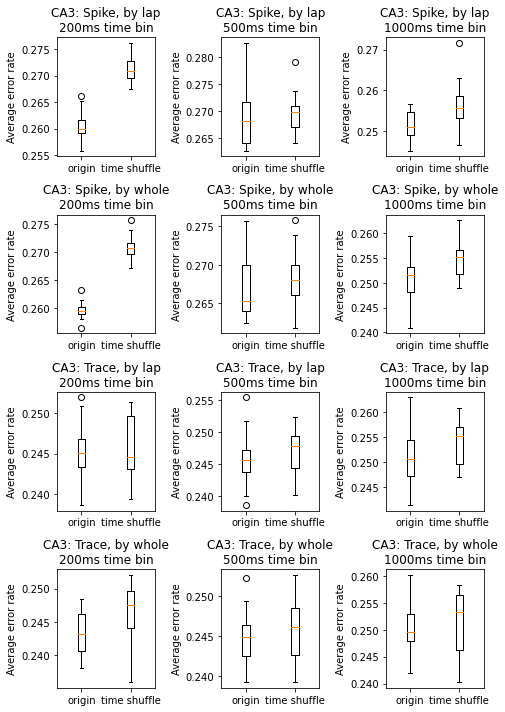

In [4]:
# time-shuffle with each lap
CA='CA3'
if CA=='CA3':
    fname='KQ086_210110'
else:
    fname='KQ095_210205'
    
timebins=[200,500,1000]
train_by_laps=['lap','whole']
names=['Spike','Trace']
    
fig, axs = plt.subplots(4, 3,sharey=False,figsize=(7,10))
for i, timebin in enumerate(timebins):
    k=0
    for name in names:
        for train_by_lap in train_by_laps:
            data=np.load(f'/Users/daiyiluo/Downloads/tsresult/{CA}_compare_ori_ts/{name}_{timebin}_err_rate_20_{train_by_lap}_1.npz')
            axs[k,i].boxplot([data['save_org_err_rate'][0], data['save_ts_err_rate'][0]])
            
            axs[k,i].set_xticks(np.arange(1,3)) 
            axs[k,i].set_xticklabels(['origin','time shuffle'])

            axs[k,i].set_ylabel('Average error rate')
            axs[k,i].set_title(f'{CA}: {name}, by {train_by_lap}\n{timebin}ms time bin')
            
            k+=1

# plt.setp(axs, ylim=(0.12,0.29))
fig.tight_layout()
plt.show()